<center>
    <tr>
    <td><img src="images/Quansight_Logo_Lockup_1.png" width="25%"></img></td>
    </tr>
</center>

# Linear Filters

## Outline

- Linear Filtering in 1D
- Cross-correlation
- Convolution
- Gaussian filter
- Gaussian blurring
- Separability
- Relationship to Fourier transform
- Integral images

In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
# Load image of Van Gogh, convert from BGR to RGB image
I = cv.imread('data/van-gogh.jpg')
I = cv.cvtColor(I, cv.COLOR_BGR2RGB)

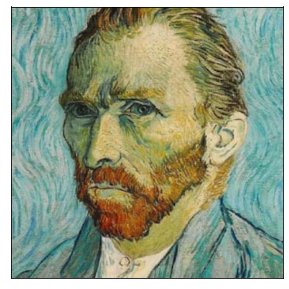

In [3]:
plt.figure(figsize=(5,5))
plt.imshow(I)
plt.xticks([])
plt.yticks([]);

Let's plot a single row of the red channel of image $I$, say, row 200.

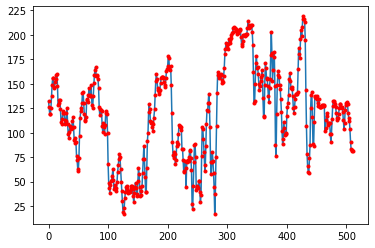

In [4]:
row = 200
rowI = I[row,:,0]
plt.figure()
plt.plot(rowI,'-')
plt.plot(rowI,'r.');

Let's perform a moving average on this row.  We assume window with half-width equal to $w$.

In [5]:
width = 5
signal = rowI
kernel = np.ones(2*width+1)/(2*width+1) # Array to represent the window (constant-valued)
result = np.ones(len(signal)-2*width)   # Array to store computed moving averages
for i in range(len(result)):
    centre = i + width
    result[i] = np.dot(kernel, signal[centre-width:centre+width+1])

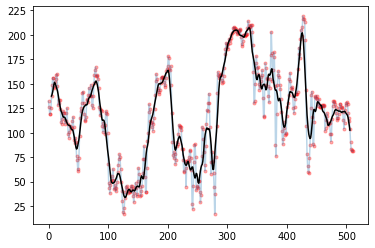

In [6]:
# Generate a plot of the original 1D signal and its average
plt.figure()
plt.plot(signal,'r.', alpha=0.3)
plt.plot(signal,'-', alpha=0.3)
plt.plot(np.arange(width, len(signal)-width),result,'k-');

## Linear Filtering in 1D

- Signal: $\mathbf{f}$
- Kernel (also sometimes called a filter or a mask): $\mathbf{h}$ 
- Half-width of the kernel: $w$ (i.e., kernel width is $2 w + 1$)

### Cross-Correlation

$$
CC(i) = \sum_{k \in [-w,w]} \mathbf{f}(i + k) \mathbf{h}(k)
$$

### Convolution

$$
(\mathbf{f} \ast \mathbf{k} )_i = \sum_{k \in [-w,w]} \mathbf{f}(i - k) \mathbf{h}(k)
$$

#### Exercise: computing a 1D convolution (from scratch)

Compute $\mathbf{f} \ast \mathbf{h}$ given

$$
\mathbf{f} = 
\left[
\begin{array}{cccccccc}
1 & 3 & 4 & 1 & 10 & 3 & 0 & 1
\end{array}
\right]
$$

and 

$$
\mathbf{h} = 
\left[
\begin{array}{ccc}
1 & 0 & -1
\end{array}\right]
$$

In [ ]:
# Your solution here

In [ ]:
# %load solutions/03/solution_01.py

### Built-in Functions for 1D Convolution

NumPy, of course, has a builtin function [`numpy.convolve`](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) for convolution that wraps the slow loop in compiled code. Notice that, with the definition above, if the original array has length $N$ and the convolution kernel has width $2w+1$, the convolved array has length $N-2w$. In `numpy.convolve`, this behaviour is enforced using the keyword argument `mode='valid'`.

#### Exercise: computing a 1D convolution (with `convolve`)

Re-compute $\mathbf{f} \ast \mathbf{h}$ using `numpy.convolve` given

$$
\mathbf{f} = 
\left[
\begin{array}{cccccccc}
1 & 3 & 4 & 1 & 10 & 3 & 0 & 1
\end{array}
\right]
$$

and 

$$
\mathbf{h} = 
\left[
\begin{array}{ccc}
1 & 0 & -1
\end{array}\right].
$$

In [ ]:
# Your solution here

In [ ]:
# %load solutions/03/solution_02.py

### Example: Gaussian smoothing for noise removal

Tasks:

- Construct a 1D (noisy) signal
- Filter this signal with a 1D Gaussian kernel to suppress the noise and improve the signal-to-noise ratio

In [ ]:
n = 20
x = np.linspace(0, np.pi, n)
y = np.sin(x)
mu = 0.0
sigma = 0.4
y_noisy = y + np.random.normal(mu, sigma, n)

plt.plot(x,y,'.-', label='data', alpha=0.5)
plt.plot(x,y_noisy,'.-r', label='noisy data')
plt.xlim(-.4,3.5)
plt.ylim(-1,2)
plt.xticks([])
plt.yticks([])
plt.legend(['data', 'noisy data']);

Gaussian function in 1d is 

$$
G(\mu,\sigma,x) = \frac{1}{\sigma \sqrt{2 \pi}} \exp ^ {- \frac{(x-\mu)^2}{2 \sigma^2}}
$$

In [ ]:
def gaussian1d(mu, sig, n, normalized=True):
    s = n//2    
    x = np.linspace(-s,s,n)
    exponent_factor = np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    normalizing_factor = 1. if not normalized else 1./(sig * np.sqrt(2*np.pi))
    return normalizing_factor * exponent_factor

In [ ]:
n = 9
sigma = 1.4

g1 = gaussian1d(0.0, sigma, n, normalized=True)
g2 = gaussian1d(0.0, sigma, n, normalized=False)

plt.plot(g1, 'r-.', label='Normalized')
plt.plot(g2, 'b-o', label='Not normalized')
plt.title('Gaussian kernels')
plt.legend(loc='center left');

In [ ]:
y_smoothed = np.convolve(y_noisy, g1, mode='same')

plt.plot(x,y,'b', label='data', alpha=0.3)
plt.plot(x,y_noisy,'r', label='noisy data', alpha=0.5)
plt.plot(x,y_smoothed,'k', label='smoothed data')
plt.xlim(-.4,3.5)
plt.ylim(-1,2)
plt.xticks([])
plt.yticks([])
plt.legend(loc='upper left')

### What do we do with the missing edge values?

We will return to this issue later.

## Linear Filter in 2D

- Signal: $\mathbf{f}$
- Kernel (also sometimes called a filter or a mask): $\mathbf{h} \in \mathbb{R}^{(2w+1)\times(2h+1)}$  

### Cross-Correlation

$$
CC(i) = \sum_{\substack{k \in [-w,w] \\ l \in [-h,h]}} \mathbf{f}(i + k, j+l) \mathbf{h}(k,l)
$$

### Convolution

$$
(\mathbf{f} \ast \mathbf{k} )_i = = \sum_{\substack{k \in [-w,w] \\ l \in [-h,h]}} \mathbf{f}(i - k, j - l) \mathbf{h}(k,l)
$$

Convolution is equivalent to flipping the filter (kernel) in both directions.  Convolution and cross-correlation are the same for symmetric filters. 

### Example 1: Averaging Kernels 

In [ ]:
average_3_by_3 = np.array([[1,1,1],
                           [1,1,1],
                           [1,1,1]], dtype='float32')/9.

average_5_by_5 = np.array([[1,1,1,1,1],
                           [1,1,1,1,1],
                           [1,1,1,1,1],
                           [1,1,1,1,1],
                           [1,1,1,1,1]], dtype='float32')/25.


average_7_by_7 = np.array([[1,1,1,1,1,1,1],
                           [1,1,1,1,1,1,1],
                           [1,1,1,1,1,1,1],
                           [1,1,1,1,1,1,1],
                           [1,1,1,1,1,1,1],
                           [1,1,1,1,1,1,1],
                           [1,1,1,1,1,1,1]], dtype='float32')/49.

In [ ]:
I_gray = cv.cvtColor(I, cv.COLOR_RGB2GRAY)

I3 = sp.signal.convolve2d(I_gray, average_3_by_3, mode='same')
I5 = sp.signal.convolve2d(I_gray, average_5_by_5, mode='same')
I7 = sp.signal.convolve2d(I_gray, average_7_by_7, mode='same')

plt.figure(figsize=(20,10))
plt.subplot(241)
plt.imshow(I_gray, cmap='gray')
plt.subplot(242)
plt.imshow(I3, cmap='gray')
plt.subplot(243)
plt.imshow(I5, cmap='gray')
plt.subplot(244)
plt.imshow(I7, cmap='gray')
plt.subplot(245)
plt.imshow(I_gray[215:290,175:250], cmap='gray')
plt.subplot(246)
plt.imshow(I3[215:290,175:250], cmap='gray')
plt.subplot(247)
plt.imshow(I5[215:290,175:250], cmap='gray')
plt.subplot(248)
plt.imshow(I7[215:290,175:250], cmap='gray');

### Example 2: A Kernel that shifts images by two pixels

In [ ]:
shift_right = np.array([[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,0,0,0,1],
                        [0,0,0,0,0],
                        [0,0,0,0,0]], dtype='float32')

shift_left = np.array([[0,0,0,0,0],
                       [0,0,0,0,0],
                       [1,0,0,0,0],
                       [0,0,0,0,0],
                       [0,0,0,0,0]], dtype='float32')

### Example 3: A Kernel for finding image edges 

In [ ]:
sobel_x = np.array([[1,2,1],
                    [0,0,0],
                    [-1,-2,-1]], dtype='float32')

sobel_y = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]], dtype='float32')

In [ ]:
E_vertical = sp.signal.convolve2d(I_gray, sobel_y, mode='same')
E_horizontal = sp.signal.convolve2d(I_gray, sobel_x, mode='same')

plt.figure(figsize=(20,10))
plt.subplot(231)
plt.imshow(I_gray, cmap='gray')
plt.subplot(232)
plt.imshow(E_vertical, cmap='gray')
plt.subplot(233)
plt.imshow(E_horizontal, cmap='gray');

### Example 4: Gaussian Blurring

Gaussian function in $k$ dimensions is
$$
G(\mathbf{\mu},\Sigma,\mathbf{x}) = \frac{\exp ^{-\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu})}}{\sqrt{ (2 \pi)^{k} \det(\Sigma) }} 
$$
where $\Sigma\in\mathbb{R}^{k\times k}$ is the (symmetric positive definite) *covariance* matrix, and $\mu\in\mathbb{R}^{k\times1}$ is the *mean*.

In [ ]:
# Evaluates 2D Gaussian on xy grid.
# xy is two channel 2D matrix.  The first channel stores x coordinates
# [-1 0 1]
# [-1 0 1]
# [-1 0 1]
# and the second channel stores y coordinates
# [-1 -1 -1]
# [0   0  0]
# [1   1  1]
# So then we can pick out an xy value using xy[i,j,:].
# Check out gaussian2_n() to see how you can construct such
# an xy using numpy
#
# For gaussian2_xy() and gaussian2_n() methods
# mean is a 2x1 vector and cov is a 2x2 matrix

def gaussian2_xy(mean, cov, xy):
    invcov = np.linalg.inv(cov)
    results = np.ones([xy.shape[0], xy.shape[1]])
    for x in range(0, xy.shape[0]):
        for y in range(0, xy.shape[1]):
            v = xy[x,y,:].reshape(2,1) - mean
            results[x,y] = np.dot(np.dot(np.transpose(v), invcov), v)
    results = np.exp( - results / 2 )
    return results 

def gaussian2_n(mean, cov, n):
    s = n//2
    x = np.linspace(-s,s,n)
    y = np.linspace(-s,s,n)
    xc, yc = np.meshgrid(x, y)
    xy = np.zeros([n, n, 2])
    xy[:,:,0] = xc
    xy[:,:,1] = yc

    return gaussian2_xy(mean, cov, xy), xc, yc

def gaussian2d(var, n):
    mean =  np.array([0, 0])
    mean = mean.reshape(2,1)
    cov = np.array([[var,0],[0,var]])
    k, xc, yc = gaussian2_n(mean, cov, n)
    return k
    
n = 111
mean =  np.array([0, 0])
mean = mean.reshape(2,1)
cov = np.array([[20,0],[0,20]])
g2d_kernel, xc, yc = gaussian2_n(mean, cov, 11)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xc, yc, g2d_kernel,rstride=1, cstride=1, cmap='coolwarm',
                       linewidth=0, antialiased=False)

In [ ]:
# Don't forget to normalize the kernel weights.
g2d_kernel_normalized = g2d_kernel / np.sum(g2d_kernel)

# Use scipy.signal.convolve2d for 2D convolutions
img_gaussian_smooth = sp.signal.convolve2d(I_gray, g2d_kernel_normalized, mode='same', boundary='fill')

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Image')
plt.imshow(I_gray,cmap='gray')
plt.subplot(132)
plt.title('Kernel')
plt.imshow(g2d_kernel_normalized)
plt.subplot(133)
plt.title('Smoothed image')
plt.imshow(img_gaussian_smooth,cmap='gray');

## Gaussian Filter

<figure style="margin-left:auto; margin-right: auto; text-align: center; display: block; max-width: 700px;">
<img src="images/gaussian.png" alt="Drawing" style="width: 300px;"/>
<figcaption style="text-align: center; margin-bottom: 10px; font-style: italic;">Courtesy K. Grauman</figcaption>
</figure>

- We often use the following approximation of the Gaussian function

$$
\frac{1}{16}
\left[
\begin{array}{ccc}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{array}
\right]
$$

- Gaussian function has *infinite* support, but discrete filters use finite kernels

<figure style="margin-left:auto; margin-right: auto; text-align: center; display: block; max-width: 700px;">
<img src="images/gaussian-width.png" alt="Drawing" style="width: 300px;"/>
<figcaption style="text-align: center; margin-bottom: 10px; font-style: italic;">Courtesy K. Grauman</figcaption>
</figure>

- Variance controls how broad or peaky the filter is

<figure style="margin-left:auto; margin-right: auto; text-align: center; display: block; max-width: 700px;">
<img src="images/gaussian-width.png" alt="Drawing" style="width: 300px;"/>
<figcaption style="text-align: center; margin-bottom: 10px; font-style: italic;">Courtesy K. Grauman</figcaption>
</figure>

- Blurs the image, i.e., removes "high-frequency" components from the image (acts as low-pass filter)
- Convolution with itself is a Gaussian
- Convolving twice with Gaussian kernel of width $\sigma$ is the same as convolving once with kernel of width $\sigma \sqrt{2}$
- Applying a Gaussian filter with variance $\sigma_1$, followed by applying a Guassian filter with variance $\sigma_2$ is the same as applying once with Gaussian filter with variance $\sqrt{\sigma_1^2 + \sigma_2^2}$
- All values are positive
- Values sum to $1$?  Why is this relevant?
- This size of the filter, plus its variance, determines the extent of smoothing

#### Exercise: applying 2D Gaussian & averaging kernels

Constuct a $15 \times 15$ Gaussian kernel of variance $7$ and blur the image `I_gray`.  Also blur `I_gray` with a $23 \times 23$ averaging kernel.  Compare the results.

In [ ]:
# Your solution here

In [ ]:
# %load solutions/03/solution_03.py

## Separability

A $n$-dimensional filter that can be expressed as an *outer product* of $n$ 1-dimensional filters is called a *separable* filter.

**Example**

$$
\left[
\begin{array}{ccc}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{array}
\right]
=
\left[
\begin{array}{c}
1 \\
2 \\
1
\end{array}
\right]
\left[
\begin{array}{ccc}
1 & 2 & 1
\end{array}
\right]
$$

### Convolutions with Separable Filters (in 2D)

- **Step 1**: Perform row-wise convolution with horizontal filter
- **Step 2**: Perform column-wise convolution of the result obtained in Step 1 with the vertical filter

<figure style="margin-left:auto; margin-right: auto; text-align: center; display: block; max-width: 700px;">
<img src="images/separable.png" alt="Drawing" style="width: 600px;"/>
<figcaption style="text-align: center; margin-bottom: 10px; font-style: italic;">Courtesy S. Fidler</figcaption>
</figure>

#### Computational considerations

Where possible exploit separability to speed up convolutions.  Say $w_k$ and $h_k$ denote kernel width and height, respectively, and $w$ and $h$ denote image width and height, respectively, then

- For separable filters: $\mathcal{O}(w_k \times w \times h) + \mathcal{O}(h_k \times w \times h)$ 

- For non-separable filters: $\mathcal{O}(w_k \times h_k \times w \times h)$

### Separable Filters

- Use Singular Value Decomposition (SVD) to determine if a filter is separable.  If only one singular value is non-zero then the filter is separable.

**Recipe**

(Step 1) Compute SVD, and check if only one singular value is non-zero 

$$
F = \mathbf{U} \Sigma \mathbf{V}^T = \sum_i \sigma_i \mathbf{u}_i \mathbf{v}_i^T,
$$

where $\Sigma = \mathrm{diag}(\sigma_i)$.

(Step 2). Vertical and horizontal filters are: $\sqrt{\sigma_1}\mathbf{u}_1$ and $\sqrt{\sigma_1}\mathbf{v}_1^T$

In [ ]:
F = np.array([1,2,1,2,4,2,1,2,1]).reshape(3,3)
print('F =\n{}'.format(F))

print(np.linalg.matrix_rank(F))

u, s, vh = np.linalg.svd(F)
print(f'Singular values of F are: {s}')

print(u)
print(vh)

In [ ]:
if s[~np.isclose(s, 0)].shape == (1,):
    print('Filter F_original is separable')
    ind = np.where(np.isclose(s, 0) == False)[0][0]
    s_1 = s[~np.isclose(s, ind)]
    fv = np.sqrt(s_1)*u[:,ind].reshape(3,1)
    fh = np.sqrt(s_1)*vh[ind,:].reshape(1,3)
    print('fv:\n {}'.format(fv))
    print('fh:\n {}'.format(fh))
    print('F_reconstructed:\n {}'.format(np.dot(fv, fh)))
else:
    print('Filter F is not separable')

In [ ]:
S = np.array([2,3,3,3,5,5,4,4,6]).reshape(3,3)

print('S*F: \n{}'.format(sp.signal.convolve2d(S, F, mode='valid')))

Sv = sp.signal.convolve2d(S, fv, mode='valid')
print('Sv=S*fv: \n{}'.format(Sv))
print('Sv*fh: \n{}'.format(sp.signal.convolve2d(Sv, fh, mode='valid')))

## Dealing with Missing Values

- Set missing entries to a particular value, say $0$

<figure style="margin-left:auto; margin-right: auto; text-align: center; display: block; max-width: 700px;">
<img src="images/conv-missing-values-0.png" alt="Drawing" style="width: 600px;"/>
</figure>

- Repeat boundary entries

<figure style="margin-left:auto; margin-right: auto; text-align: center; display: block; max-width: 700px;">
<img src="images/conv-missing-values-rep.png" alt="Drawing" style="width: 600px;"/>
</figure>

- Wrap around (this is useful to create an infinite domain)

<figure style="margin-left:auto; margin-right: auto; text-align: center; display: block; max-width: 700px;">
<img src="images/conv-missing-values-wrap.png" alt="Drawing" style="width: 600px;"/>
</figure>

- Do nothing.  This is often not done, since the output size is not the same as the input size, which creates a host of practical issues. 

<figure style="margin-left:auto; margin-right: auto; text-align: center; display: block; max-width: 700px;">
<img src="images/conv-missing-values-nothing.png" alt="Drawing" style="width: 600px;"/>
</figure>

## Linear Filtering

- Linearity

$$
\mathtt{filter}(\alpha_1 f_1 + \alpha_2 f_2) = \alpha_1 \mathtt{filter}(f_1) + \alpha_2 \mathtt{filter}(f_2)
$$

- Shift-invariance

$$
\mathtt{filter}(\mathtt{shift}(f)) = \mathtt{shift}(\mathtt{filter}(f))
$$

**Any linear shift-invariant filter can be represented as a convolution.**

## Properties of Convolution

- Commulative: $a \ast b = b \ast a$
- Associative: $a \ast (b \ast c) = (a \ast b) \ast c$
- Distributes over addition: $a \ast (b+c) = a \ast b + a \ast c$
- Scalars factors out: $ka \ast b = a \ast kb = k (a \ast b)$
- Identity: $ a \ast e = a$, where $e$ is unit impulse

## Relationship to Fourier Transform

The Fourier transform of two convolved signals is the element-wise (sometimes called Hadamard) product of their individual Fourier transforms:

$$
\mathcal{F}\left\{f \ast h\right\} = \mathcal{F}\left\{f\right\}\mathcal{F}\left\{h\right\}.
$$

This also suggests that

$$
f \ast h = \mathcal{F}^{-1} \left\{ \mathcal{F}\left\{f\right\}\mathcal{F}\left\{h\right\} \right\}.
$$

This is an important result.  Why?  Consider the relative complexity of compute $f \ast h$ using the Fourier transform trick ...

**Note**: there are many subtleties to what is meant by "the Fourier Transform," i.e., for signals on an unbounded, continuous domain (defined by integrals) or signals on a discrete bounded domain (the "discrete Fourier transform") and so on.
+ For computational comparisons in Python, please consult [*The Convolution Theorem & Application Examples*](https://dspillustrations.com/pages/posts/misc/the-convolution-theorem-and-application-examples.html)  at [`dspillustrations.com`](https://dspillustrations.com)
+ An excellent technical reference is Briggs & Henson's [*The DFT: An Owner's Manual for the Discrete Fourier Transform*](https://epubs.siam.org/doi/book/10.1137/1.9781611971514) that is very precise, comprehensive, and readable.

## (Aside) Integral Images

Given an image $X[i,j]$, we compute the integral image as follows:
    
$$
S[m,n]=\sum_{i \le m} \sum_{j \le n} X[i,j]
$$

(think of cumulative sums along both dimensions of an array).

In [ ]:
X = np.array([1,2,3,-1,3,2,34,5,3,2,3,2,3,42,5,-3,1,4,98,3,1,2,3,2,5], dtype=np.float32).reshape(5,5)
print('X:\n {}'.format(X))
S = cv.integral(X)[1:,1:]
print('Integral image of X:\n {}'.format(S))

### Uses of Integral Images

No matter the size of summing window, we can compute sum using 3 arithmetic operations

<figure style="margin-left:auto; margin-right: auto; text-align: center; display: block; max-width: 700px;">
<img src="images/integral-image.png" alt="Drawing" style="width: 600px;"/>
</figure>


---
Based on materials from Prof. Faisal Qureshi (Faculty of Science, Ontario Tech University, Oshawa ON, Canada, http://vclab.science.ontariotechu.ca)

<center>
    <tr>
    <td><img src="images/Quansight_Logo_Lockup_1.png" width="25%"></img></td>
    </tr>
</center>